In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

device = torch.device('cpu')


In [2]:
# Define the exact solution
def exact_solution_u(x, t):
    return (2.5*pi*torch.cos(x)+(x-pi*2.5))*torch.cos(t)

def initial_condition_u(x):
    return 2.5*pi*torch.cos(x) + (x - pi*2.5)

def initial_condition_u_t(x):
    return 0.0*pi*torch.cos(x)

# Define the exact solution
def exact_solution_p(x, t):
    return 2.5*pi*torch.sin(x)*torch.cos(t)

def initial_condition_p(x):
    return 2.5*pi*torch.sin(x)

def initial_condition_p_t(x):
    return 0.0*pi*torch.cos(x)

# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

eps = 5
manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = 5*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1).to(device)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1).to(device)
w_init = torch.cat([u_init, p_init],1).to(device)

u_t_init = initial_condition_u_t(init[:,0]).reshape(-1, 1).to(device)
p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1).to(device)
w_t_init = torch.cat([u_t_init, p_t_init],1).to(device)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = exact_solution_u(xb_left, tb_left).to(device)
p_b_l = exact_solution_p(xb_left, tb_left).to(device)
w_b_l = torch.cat([u_b_l, p_b_l],1).to(device)



xb_right = 5*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = exact_solution_u(xb_right, tb_right).to(device)
p_b_r = exact_solution_p(xb_right, tb_right).to(device)
w_b_r = torch.cat([u_b_r, p_b_r],1).to(device)

# x_interior = pi*torch.rand((residual_pts, 1))
# t_interior = torch.rand((residual_pts, 1))
# interior = torch.cat([x_interior, t_interior],1)

x_int = torch.linspace(0, 5*pi, 102)
x_int = x_int[1:-1]

t_int = torch.linspace(0, 1, 102)
t_int = t_int[1:-1]

x_interior = x_int.tile((100,))
x_interior = x_interior.reshape(-1,1)

t_interior = t_int.repeat_interleave(100)
t_interior = t_interior.reshape(-1,1)

# torch.set_printoptions(threshold=10_000)

interior = torch.cat([x_interior, t_interior],1).to(device)

n = 100  # size of matrix
W = torch.tril(torch.ones(n, n), diagonal=-1).to(device)  # create a lower triangular matrix of ones
W -= torch.diag(torch.diag(W)).to(device)  # set the diagonal elements to zero




training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), w_init.to(device), w_t_init.to(device), b_left.to(device),  b_right.to(device)), batch_size=2000, shuffle=False)


In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

In [4]:
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = 2, n_hidden_layers=4, neurons=200)
model_state_dict = torch.load('causal_timo.pth', map_location=torch.device('cpu'))
my_network = my_network.to(device)

# after defining my network - also dont forget to comment xavier
my_network.load_state_dict(model_state_dict)

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, w_initial, w_initial_t, bd_left, bd_right) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:, 0].reshape(-1, 1)
                p_initial_pred_ = w_initial_pred_[:, 1].reshape(-1, 1)

                # with derivative
                inpu = torch.ones(initial_pts, 1).to(device)

                grad_u_ini = \
                torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[
                    0]

                u_initial_t = grad_u_ini[:, 1]

                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]

                p_initial_t = grad_p_ini[:, 1]

                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:, 0].reshape(-1, 1)
                p_bd_left_pred_ = w_bd_left_pred_[:, 1].reshape(-1, 1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:, 0].reshape(-1, 1)
                p_bd_right_pred_ = w_bd_right_pred_[:, 1].reshape(-1, 1)

                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:, 0].reshape(-1, 1)
                p_hat = w_hat[:, 1].reshape(-1, 1)
                inputs = torch.ones(residual_pts, 1).to(device)
                inputs2 = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = \
                torch.autograd.grad(u_hat.reshape(-1, 1), interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, 1)

                grad_u_hat_xx = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]

                u_xx = grad_u_hat_xx[:, 0].reshape(-1, 1)

                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                p_x = grad_p_hat[:, 0].reshape(-1, 1)

                grad_p_hat_xx = torch.autograd.grad(p_x, interior, grad_outputs=inputs, create_graph=True)[0]

                p_xx = grad_p_hat_xx[:, 0].reshape(-1, 1)

                # grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                # u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1, 1)

                grad_u_hat_tt = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]

                u_tt = grad_u_hat_tt[:, 1].reshape(-1, 1)

                p_t = grad_p_hat[:, 1].reshape(-1, 1)
                grad_p_hat_tt = torch.autograd.grad(p_t, interior, grad_outputs=inputs, create_graph=True)[0]

                p_tt = grad_p_hat_tt[:, 1].reshape(-1, 1)

                pde_single_column = (u_tt.reshape(-1, ) - u_xx.reshape(-1, ) + u_hat.reshape(-1, ) - p_x.reshape(
                    -1, )) ** 2
                pde_single_column = pde_single_column.reshape(-1, 1)

                pde_matrix = pde_single_column.reshape(100, 100)

                loss_at_time_steps = torch.mean(pde_matrix, 1)
                loss_at_time_steps = loss_at_time_steps.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss = torch.matmul(W, loss_at_time_steps)
                weighted_loss = torch.exp(-eps * weighted_loss)

                loss_pde = torch.mean(weighted_loss * loss_at_time_steps)

                pde_single_column1 = (p_tt.reshape(-1, ) + u_x.reshape(-1, ) - p_xx.reshape(-1, ) + p_hat.reshape(
                    -1, ) - torch.cos(interior[:, 1]).reshape(-1, )) ** 2
                pde_single_column1 = pde_single_column1.reshape(-1, 1)

                pde_matrix1 = pde_single_column1.reshape(100, 100)

                loss_at_time_steps1 = torch.mean(pde_matrix1, 1)
                loss_at_time_steps1 = loss_at_time_steps1.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss1 = torch.matmul(W, loss_at_time_steps1)
                weighted_loss1 = torch.exp(-eps * weighted_loss1)

                loss_pde1 = torch.mean(weighted_loss1 * loss_at_time_steps1)

                # Item 1. below
                loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:, 0].reshape(-1, )) ** p) + torch.mean(
                    (u_initial_pred_.reshape(-1, ) - w_initial[:, 0].reshape(-1, )) ** p) + loss_pde + torch.mean(
                    (u_bd_left_pred_.reshape(-1, ) - u_b_l.reshape(-1, )) ** p) + torch.mean(
                    (u_bd_right_pred_.reshape(-1, ) - u_b_r.reshape(-1, )) ** p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:, 1].reshape(-1, )) ** p) + torch.mean(
                    (p_initial_t.reshape(-1, ) - w_initial_t[:, 1].reshape(-1, )) ** p) + loss_pde1 + torch.mean(
                    (p_bd_left_pred_.reshape(-1, ) - p_b_l.reshape(-1, )) ** p) + torch.mean(
                    (p_bd_right_pred_.reshape(-1, ) - p_b_r.reshape(-1, )) ** p)
                loss = loss1 + loss2
                # loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history



In [5]:
start_time = time.time()
n_epochs = 3000
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

end_time = time.time()
total_time = end_time - start_time
print("total_time", total_time)

with open('p9_3k.pkl', 'wb') as f:
    pickle.dump(history, f)

f.close()

model_state_dict = my_network.state_dict()

# Save the model state dictionary to a file
torch.save(model_state_dict, 'p9_3k.pth')

################################  0  ################################
Loss:  139.78408813476562
################################  1  ################################
Loss:  139.50758361816406
################################  2  ################################
Loss:  118.17695617675781
################################  3  ################################
Loss:  83.037353515625
################################  4  ################################
Loss:  66.25959777832031
################################  5  ################################
Loss:  61.818580627441406
################################  6  ################################
Loss:  58.28474807739258
################################  7  ################################
Loss:  54.66122817993164
################################  8  ################################
Loss:  51.15143966674805
################################  9  ################################
Loss:  48.01575469970703
################################  10  ##########

Loss:  2.0704073905944824
################################  86  ################################
Loss:  2.0206170082092285
################################  87  ################################
Loss:  1.9753961563110352
################################  88  ################################
Loss:  1.9301178455352783
################################  89  ################################
Loss:  1.8885784149169922
################################  90  ################################
Loss:  1.8467841148376465
################################  91  ################################
Loss:  1.8082249164581299
################################  92  ################################
Loss:  1.7693718671798706
################################  93  ################################
Loss:  1.733532428741455
################################  94  ################################
Loss:  1.697493553161621
################################  95  ################################
Loss:  1.664400577545166
#######

Loss:  0.5769656896591187
################################  170  ################################
Loss:  0.5707205533981323
################################  171  ################################
Loss:  0.564704418182373
################################  172  ################################
Loss:  0.5585733652114868
################################  173  ################################
Loss:  0.5526426434516907
################################  174  ################################
Loss:  0.546576201915741
################################  175  ################################
Loss:  0.5406851172447205
################################  176  ################################
Loss:  0.5346375703811646
################################  177  ################################
Loss:  0.5287574529647827
################################  178  ################################
Loss:  0.5227147936820984
################################  179  ################################
Loss:  0.5168495178222

Loss:  0.12857890129089355
################################  254  ################################
Loss:  0.1267905831336975
################################  255  ################################
Loss:  0.12507379055023193
################################  256  ################################
Loss:  0.12335900962352753
################################  257  ################################
Loss:  0.1216445043683052
################################  258  ################################
Loss:  0.11984255909919739
################################  259  ################################
Loss:  0.11802373081445694
################################  260  ################################
Loss:  0.11649274826049805
################################  261  ################################
Loss:  0.11505246162414551
################################  262  ################################
Loss:  0.11362531781196594
################################  263  ################################
Loss:  0.112

Loss:  0.030558433383703232
################################  337  ################################
Loss:  0.030120547860860825
################################  338  ################################
Loss:  0.029708396643400192
################################  339  ################################
Loss:  0.029307017102837563
################################  340  ################################
Loss:  0.02891937457025051
################################  341  ################################
Loss:  0.028538022190332413
################################  342  ################################
Loss:  0.028164871037006378
################################  343  ################################
Loss:  0.02784641832113266
################################  344  ################################
Loss:  0.02755051665008068
################################  345  ################################
Loss:  0.02727668359875679
################################  346  ################################
Loss

Loss:  0.010357547551393509
################################  420  ################################
Loss:  0.010259125381708145
################################  421  ################################
Loss:  0.010158139280974865
################################  422  ################################
Loss:  0.01006016880273819
################################  423  ################################
Loss:  0.009964872151613235
################################  424  ################################
Loss:  0.009878681972622871
################################  425  ################################
Loss:  0.009798023849725723
################################  426  ################################
Loss:  0.009722323156893253
################################  427  ################################
Loss:  0.00965060479938984
################################  428  ################################
Loss:  0.009580716490745544
################################  429  ################################
Lo

Loss:  0.007240076549351215
################################  503  ################################
Loss:  0.007223050110042095
################################  504  ################################
Loss:  0.0072822910733520985
################################  505  ################################
Loss:  0.00726002361625433
################################  506  ################################
Loss:  0.007238122168928385
################################  507  ################################
Loss:  0.007217486388981342
################################  508  ################################
Loss:  0.007198357954621315
################################  509  ################################
Loss:  0.007181062363088131
################################  510  ################################
Loss:  0.00716571556404233
################################  511  ################################
Loss:  0.007152304984629154
################################  512  ################################
L

Loss:  0.006714241579174995
################################  585  ################################
Loss:  0.006690310314297676
################################  586  ################################
Loss:  0.006665858905762434
################################  587  ################################
Loss:  0.006639605388045311
################################  588  ################################
Loss:  0.006610752083361149
################################  589  ################################
Loss:  0.006585716735571623
################################  590  ################################
Loss:  0.006554154213517904
################################  591  ################################
Loss:  0.006529850885272026
################################  592  ################################
Loss:  0.006506652105599642
################################  593  ################################
Loss:  0.00647953525185585
################################  594  ################################
L

Loss:  0.005886858329176903
################################  667  ################################
Loss:  0.005885952617973089
################################  668  ################################
Loss:  0.005882897414267063
################################  669  ################################
Loss:  0.005882575176656246
################################  670  ################################
Loss:  0.005877823568880558
################################  671  ################################
Loss:  0.005877498537302017
################################  672  ################################
Loss:  0.005873015150427818
################################  673  ################################
Loss:  0.005876005627214909
################################  674  ################################
Loss:  0.00587204284965992
################################  675  ################################
Loss:  0.0058691902086138725
################################  676  ################################


Loss:  0.005587819032371044
################################  749  ################################
Loss:  0.005582131445407867
################################  750  ################################
Loss:  0.005575366318225861
################################  751  ################################
Loss:  0.005567455664277077
################################  752  ################################
Loss:  0.005559638142585754
################################  753  ################################
Loss:  0.005548960529267788
################################  754  ################################
Loss:  0.005539614707231522
################################  755  ################################
Loss:  0.0055277785286307335
################################  756  ################################
Loss:  0.005517070181667805
################################  757  ################################
Loss:  0.005506747867912054
################################  758  ################################

Loss:  0.005278363823890686
################################  831  ################################
Loss:  0.0052724601700901985
################################  832  ################################
Loss:  0.005267465487122536
################################  833  ################################
Loss:  0.005262867547571659
################################  834  ################################
Loss:  0.005258955992758274
################################  835  ################################
Loss:  0.005255051888525486
################################  836  ################################
Loss:  0.0052519384771585464
################################  837  ################################
Loss:  0.005250399000942707
################################  838  ################################
Loss:  0.005248264875262976
################################  839  ################################
Loss:  0.005246346816420555
################################  840  ###############################

Loss:  0.005057917907834053
################################  913  ################################
Loss:  0.005049877800047398
################################  914  ################################
Loss:  0.005041784606873989
################################  915  ################################
Loss:  0.005032990127801895
################################  916  ################################
Loss:  0.005020212382078171
################################  917  ################################
Loss:  0.005013366229832172
################################  918  ################################
Loss:  0.0050063906237483025
################################  919  ################################
Loss:  0.005000407341867685
################################  920  ################################
Loss:  0.0049942731857299805
################################  921  ################################
Loss:  0.004989387467503548
################################  922  ###############################

Loss:  0.004845571704208851
################################  995  ################################
Loss:  0.0048444634303450584
################################  996  ################################
Loss:  0.004843353293836117
################################  997  ################################
Loss:  0.004844712093472481
################################  998  ################################
Loss:  0.00484409648925066
################################  999  ################################
Loss:  0.004842734895646572
################################  1000  ################################
Loss:  0.004841521382331848
################################  1001  ################################
Loss:  0.004839948378503323
################################  1002  ################################
Loss:  0.00483819842338562
################################  1003  ################################
Loss:  0.004835400730371475
################################  1004  #############################

Loss:  0.004857632797211409
################################  1077  ################################
Loss:  0.004853431601077318
################################  1078  ################################
Loss:  0.004852263256907463
################################  1079  ################################
Loss:  0.004849754273891449
################################  1080  ################################
Loss:  0.004850521683692932
################################  1081  ################################
Loss:  0.004849792458117008
################################  1082  ################################
Loss:  0.004852930083870888
################################  1083  ################################
Loss:  0.004854627884924412
################################  1084  ################################
Loss:  0.00485872570425272
################################  1085  ################################
Loss:  0.004862184636294842
################################  1086  ########################

Loss:  0.005092961248010397
################################  1159  ################################
Loss:  0.0050932737067341805
################################  1160  ################################
Loss:  0.005095711909234524
################################  1161  ################################
Loss:  0.005095599684864283
################################  1162  ################################
Loss:  0.0051957834511995316
################################  1163  ################################
Loss:  0.005180205684155226
################################  1164  ################################
Loss:  0.005164594389498234
################################  1165  ################################
Loss:  0.005153443664312363
################################  1166  ################################
Loss:  0.005141406320035458
################################  1167  ################################
Loss:  0.005133233033120632
################################  1168  #####################

Loss:  0.005311208311468363
################################  1241  ################################
Loss:  0.005312912166118622
################################  1242  ################################
Loss:  0.005317001137882471
################################  1243  ################################
Loss:  0.005318013019859791
################################  1244  ################################
Loss:  0.00533469021320343
################################  1245  ################################
Loss:  0.0053389789536595345
################################  1246  ################################
Loss:  0.005341240204870701
################################  1247  ################################
Loss:  0.005345727317035198
################################  1248  ################################
Loss:  0.005346418358385563
################################  1249  ################################
Loss:  0.0053503504022955894
################################  1250  ######################

Loss:  0.005039391107857227
################################  1323  ################################
Loss:  0.005033130757510662
################################  1324  ################################
Loss:  0.005028882063925266
################################  1325  ################################
Loss:  0.0050237104296684265
################################  1326  ################################
Loss:  0.005068754777312279
################################  1327  ################################
Loss:  0.00505452323704958
################################  1328  ################################
Loss:  0.005041507072746754
################################  1329  ################################
Loss:  0.00502869114279747
################################  1330  ################################
Loss:  0.00501751434057951
################################  1331  ################################
Loss:  0.005004107486456633
################################  1332  #########################

Loss:  0.0047951070591807365
################################  1405  ################################
Loss:  0.004798669368028641
################################  1406  ################################
Loss:  0.004801802337169647
################################  1407  ################################
Loss:  0.0048051755875349045
################################  1408  ################################
Loss:  0.00480884313583374
################################  1409  ################################
Loss:  0.004812791012227535
################################  1410  ################################
Loss:  0.0048164622858166695
################################  1411  ################################
Loss:  0.004820465110242367
################################  1412  ################################
Loss:  0.004823771771043539
################################  1413  ################################
Loss:  0.004827625118196011
################################  1414  #####################

Loss:  0.004852717742323875
################################  1487  ################################
Loss:  0.004852614365518093
################################  1488  ################################
Loss:  0.0048516299575567245
################################  1489  ################################
Loss:  0.004850341472774744
################################  1490  ################################
Loss:  0.004848587792366743
################################  1491  ################################
Loss:  0.0048464760184288025
################################  1492  ################################
Loss:  0.004844311159104109
################################  1493  ################################
Loss:  0.004841773770749569
################################  1494  ################################
Loss:  0.004839681554585695
################################  1495  ################################
Loss:  0.004837401676923037
################################  1496  #####################

Loss:  0.004806356970220804
################################  1569  ################################
Loss:  0.004804360680282116
################################  1570  ################################
Loss:  0.004803414456546307
################################  1571  ################################
Loss:  0.004801427014172077
################################  1572  ################################
Loss:  0.004801172763109207
################################  1573  ################################
Loss:  0.004799403250217438
################################  1574  ################################
Loss:  0.004799733404070139
################################  1575  ################################
Loss:  0.004799459129571915
################################  1576  ################################
Loss:  0.004800423514097929
################################  1577  ################################
Loss:  0.004800529684871435
################################  1578  #######################

Loss:  0.004885036963969469
################################  1651  ################################
Loss:  0.004887059330940247
################################  1652  ################################
Loss:  0.004888704977929592
################################  1653  ################################
Loss:  0.004890453536063433
################################  1654  ################################
Loss:  0.004891586489975452
################################  1655  ################################
Loss:  0.004893112927675247
################################  1656  ################################
Loss:  0.004893735516816378
################################  1657  ################################
Loss:  0.004895217251032591
################################  1658  ################################
Loss:  0.0048949820920825005
################################  1659  ################################
Loss:  0.004896670579910278
################################  1660  ######################

Loss:  0.004972281865775585
################################  1733  ################################
Loss:  0.004969613626599312
################################  1734  ################################
Loss:  0.0049670664593577385
################################  1735  ################################
Loss:  0.004964101128280163
################################  1736  ################################
Loss:  0.0049606747925281525
################################  1737  ################################
Loss:  0.0049573578871786594
################################  1738  ################################
Loss:  0.004953324794769287
################################  1739  ################################
Loss:  0.004949771799147129
################################  1740  ################################
Loss:  0.004945181775838137
################################  1741  ################################
Loss:  0.004941217601299286
################################  1742  ####################

Loss:  0.0047411746345460415
################################  1815  ################################
Loss:  0.004730356857180595
################################  1816  ################################
Loss:  0.004719849675893784
################################  1817  ################################
Loss:  0.00470963679254055
################################  1818  ################################
Loss:  0.0046998318284749985
################################  1819  ################################
Loss:  0.004689627327024937
################################  1820  ################################
Loss:  0.004680429585278034
################################  1821  ################################
Loss:  0.004670989699661732
################################  1822  ################################
Loss:  0.004662723280489445
################################  1823  ################################
Loss:  0.004654465243220329
################################  1824  ######################

Loss:  0.0036738025955855846
################################  1897  ################################
Loss:  0.0036629359237849712
################################  1898  ################################
Loss:  0.0036587475333362818
################################  1899  ################################
Loss:  0.0036475188098847866
################################  1900  ################################
Loss:  0.0036372868344187737
################################  1901  ################################
Loss:  0.003627518657594919
################################  1902  ################################
Loss:  0.0036185027565807104
################################  1903  ################################
Loss:  0.0036100302822887897
################################  1904  ################################
Loss:  0.003602140350267291
################################  1905  ################################
Loss:  0.0035946976859122515
################################  1906  ###############

Loss:  0.003025877522304654
################################  1978  ################################
Loss:  0.003017190843820572
################################  1979  ################################
Loss:  0.00300941476598382
################################  1980  ################################
Loss:  0.0030020871199667454
################################  1981  ################################
Loss:  0.002995262388139963
################################  1982  ################################
Loss:  0.002987670712172985
################################  1983  ################################
Loss:  0.002980901626870036
################################  1984  ################################
Loss:  0.0029743497725576162
################################  1985  ################################
Loss:  0.0029676994308829308
################################  1986  ################################
Loss:  0.0029613131191581488
################################  1987  ####################

Loss:  0.0025055566802620888
################################  2059  ################################
Loss:  0.0025019000750035048
################################  2060  ################################
Loss:  0.0024981782771646976
################################  2061  ################################
Loss:  0.002494341228157282
################################  2062  ################################
Loss:  0.002490543294698
################################  2063  ################################
Loss:  0.0024864389561116695
################################  2064  ################################
Loss:  0.0024820584803819656
################################  2065  ################################
Loss:  0.0024779208470135927
################################  2066  ################################
Loss:  0.00247368635609746
################################  2067  ################################
Loss:  0.002469189465045929
################################  2068  #####################

Loss:  0.0020050103776156902
################################  2140  ################################
Loss:  0.001996674109250307
################################  2141  ################################
Loss:  0.0019897171296179295
################################  2142  ################################
Loss:  0.0019821219611912966
################################  2143  ################################
Loss:  0.001973816193640232
################################  2144  ################################
Loss:  0.0019664380233734846
################################  2145  ################################
Loss:  0.001959477085620165
################################  2146  ################################
Loss:  0.0019509458215907216
################################  2147  ################################
Loss:  0.0019443456549197435
################################  2148  ################################
Loss:  0.0019371353555470705
################################  2149  ################

Loss:  0.0016122694360092282
################################  2221  ################################
Loss:  0.001608017017133534
################################  2222  ################################
Loss:  0.0016038857866078615
################################  2223  ################################
Loss:  0.0015999212628230453
################################  2224  ################################
Loss:  0.0015959617448970675
################################  2225  ################################
Loss:  0.0015915522817522287
################################  2226  ################################
Loss:  0.0015872324584051967
################################  2227  ################################
Loss:  0.001583076547831297
################################  2228  ################################
Loss:  0.001579091651365161
################################  2229  ################################
Loss:  0.0015751037281006575
################################  2230  ################

Loss:  0.0013094369787722826
################################  2302  ################################
Loss:  0.0013062768848612905
################################  2303  ################################
Loss:  0.0013029478723183274
################################  2304  ################################
Loss:  0.0013002286432310939
################################  2305  ################################
Loss:  0.0012972557451575994
################################  2306  ################################
Loss:  0.0012942883186042309
################################  2307  ################################
Loss:  0.0012911716476082802
################################  2308  ################################
Loss:  0.0012872668448835611
################################  2309  ################################
Loss:  0.0012843059375882149
################################  2310  ################################
Loss:  0.0012813652865588665
################################  2311  #############

Loss:  0.0011192936217412353
################################  2383  ################################
Loss:  0.0011177881387993693
################################  2384  ################################
Loss:  0.0011162282899022102
################################  2385  ################################
Loss:  0.0011148233897984028
################################  2386  ################################
Loss:  0.0011135094100609422
################################  2387  ################################
Loss:  0.001112279249355197
################################  2388  ################################
Loss:  0.0011111132334917784
################################  2389  ################################
Loss:  0.0011100172996520996
################################  2390  ################################
Loss:  0.0011089645558968186
################################  2391  ################################
Loss:  0.0011079697869718075
################################  2392  ##############

Loss:  0.0009510435629636049
################################  2464  ################################
Loss:  0.0009493277175351977
################################  2465  ################################
Loss:  0.0009476778795942664
################################  2466  ################################
Loss:  0.0009459921857342124
################################  2467  ################################
Loss:  0.0009443416493013501
################################  2468  ################################
Loss:  0.0009425774915143847
################################  2469  ################################
Loss:  0.0009407185716554523
################################  2470  ################################
Loss:  0.0009385846788063645
################################  2471  ################################
Loss:  0.0009365394944325089
################################  2472  ################################
Loss:  0.0009341897093690932
################################  2473  #############

Loss:  0.0008062049164436758
################################  2545  ################################
Loss:  0.0008035362116061151
################################  2546  ################################
Loss:  0.0008003598777577281
################################  2547  ################################
Loss:  0.000797970627900213
################################  2548  ################################
Loss:  0.0007951940060593188
################################  2549  ################################
Loss:  0.0007924936944618821
################################  2550  ################################
Loss:  0.0007897525792941451
################################  2551  ################################
Loss:  0.0007872291025705636
################################  2552  ################################
Loss:  0.0007848740788176656
################################  2553  ################################
Loss:  0.0007826454238966107
################################  2554  ##############

Loss:  0.0006799609400331974
################################  2626  ################################
Loss:  0.0006784987635910511
################################  2627  ################################
Loss:  0.0006770892068743706
################################  2628  ################################
Loss:  0.0006753294728696346
################################  2629  ################################
Loss:  0.0006741503602825105
################################  2630  ################################
Loss:  0.0006728116422891617
################################  2631  ################################
Loss:  0.0006715919589623809
################################  2632  ################################
Loss:  0.000670052133500576
################################  2633  ################################
Loss:  0.0006688828580081463
################################  2634  ################################
Loss:  0.0006676674820482731
################################  2635  ##############

Loss:  0.0005736451130360365
################################  2707  ################################
Loss:  0.000573022523894906
################################  2708  ################################
Loss:  0.0005724058719351888
################################  2709  ################################
Loss:  0.0005717484746128321
################################  2710  ################################
Loss:  0.0005710928235203028
################################  2711  ################################
Loss:  0.0005702909547835588
################################  2712  ################################
Loss:  0.0005695687723346055
################################  2713  ################################
Loss:  0.0005686922231689095
################################  2714  ################################
Loss:  0.0005679444875568151
################################  2715  ################################
Loss:  0.0005669774254783988
################################  2716  ##############

Loss:  0.0004961993545293808
################################  2788  ################################
Loss:  0.0004955576732754707
################################  2789  ################################
Loss:  0.0004949650028720498
################################  2790  ################################
Loss:  0.0004943921812810004
################################  2791  ################################
Loss:  0.0004938326310366392
################################  2792  ################################
Loss:  0.0004933018935844302
################################  2793  ################################
Loss:  0.000492757186293602
################################  2794  ################################
Loss:  0.0004922366933897138
################################  2795  ################################
Loss:  0.0004917359328828752
################################  2796  ################################
Loss:  0.0004912151489406824
################################  2797  ##############

Loss:  0.0004459894262254238
################################  2869  ################################
Loss:  0.00044493970926851034
################################  2870  ################################
Loss:  0.0004438917967490852
################################  2871  ################################
Loss:  0.0004426523810252547
################################  2872  ################################
Loss:  0.00044152242480777204
################################  2873  ################################
Loss:  0.0004403609491419047
################################  2874  ################################
Loss:  0.00043938931776210666
################################  2875  ################################
Loss:  0.0004383138148114085
################################  2876  ################################
Loss:  0.00043733182246796787
################################  2877  ################################
Loss:  0.0004361782339401543
################################  2878  #########

Loss:  0.0003893256071023643
################################  2950  ################################
Loss:  0.00038859760388731956
################################  2951  ################################
Loss:  0.00038790813414379954
################################  2952  ################################
Loss:  0.0003872769884765148
################################  2953  ################################
Loss:  0.0003866406041197479
################################  2954  ################################
Loss:  0.0003860801225528121
################################  2955  ################################
Loss:  0.00038552010664716363
################################  2956  ################################
Loss:  0.0003849542699754238
################################  2957  ################################
Loss:  0.00038441969081759453
################################  2958  ################################
Loss:  0.00038389599649235606
################################  2959  ########

In [6]:
# ## loading the data

# # Load the history from the pickle file
# with open('p9_3k.pkl', 'rb') as f:
#     history = pickle.load(f)

# # # Load the model architecture
# # my_network = your_model_module.YourModelClass()  # Instantiate your model class

# # Load the saved model state dictionary
# model_state_dict = torch.load('p9_3k.pth', map_location=torch.device('cpu'))

# # Load the model weights
# my_network.load_state_dict(model_state_dict)


Relative Error Test:  6.617839289901895e-05 %
Relative Error Test:  0.00011883114439115161 %


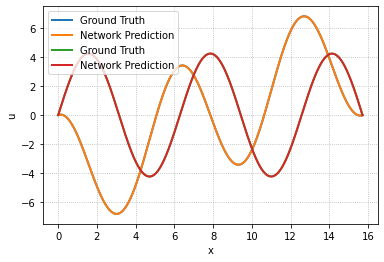

In [7]:
x_test = torch.linspace(0, 5*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
my_network = my_network.cpu()
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")